# Two-qubit gate learning with crosstalk
This notebook is designed to test noise learning through two-qubit clifford gates with crosstalk. I still have questions about how to do this while simultaneously twirling the noise. This example uses a pauli-channel noise model.

In [11]:
from qiskit.quantum_info import Operator, Pauli 
from qiskit.circuit.library import CXGate, CZGate, HGate, SGate
from qiskit import QuantumCircuit, Aer, execute
from qiskit.providers.aer.noise import depolarizing_error, NoiseModel

import numpy as np
from random import choices
from numpy.random import permutation
import matplotlib.pyplot as plt
from itertools import product
from scipy.optimize import curve_fit

In [12]:
#convenient names for common operators
I = Operator(np.identity(2))
H = Operator(HGate())
CX = Operator(CXGate())
CZ = Operator(CZGate())
X = Operator(Pauli('X'))
Y = Operator(Pauli('Y'))
Z = Operator(Pauli('Z'))
S = Operator(SGate())
IH = I.tensor(H)
HI = H.tensor(I)

#dimension of the system
n = 2

#iterate through all pauli strings and convert them to operators. indices are a convenient representation of ops
names = ["".join(str) for str in product(['I', 'X', 'Y','Z'], repeat=n)]
paulis = [Operator(Pauli(name)) for name in names]

#match pauli names with operators, so pauli_dict[name] = Operator(Pauli(name))
pauli_dict = dict(zip(names, paulis))

#give this function a pauli matrix and it returns its name if it is on the list, e.g. "XIYZ"
def get_name(pauli_op):
    try:
        #iterate through gates and check if they are equivalent up to global phase
        return names[min([i for (i,gate) in enumerate(paulis) if pauli_op.equiv(gate)])]
    except:
        return -1

#simplifying conjugating a pauli by a clifford
def conjugate(op1, op2):
    return op2.compose(op1).compose(op2.adjoint())

#get a random pauli of a specified weight
def sample_pauli(weight):
    if weight > n:
        return -1
    return pauli_dict["".join(permutation(choices(['X', 'Y','Z'], k=weight)+['I']*(n-weight)))]

In [13]:
#generate all of the paulis with support on connected qubit pairs and on the single qubits
def generate_paulis(adjacency_list, proc_size):
    pauli_list = []
    idPauli = ['I']*proc_size
    
    #get all single-weight paulis
    for i in range(proc_size):
        for op in ['X','Y','Z']:
            pauli = idPauli.copy()
            pauli[i] = op
            pauli_list.append("".join(pauli))

    #get all weight-two paulis on nieghboring qubits
    for (qubit1, qubit2) in adjacency_list:
        for pauli1, pauli2 in product(['X','Y','Z'], repeat =2):
            pauli = idPauli.copy()
            pauli[qubit1] = pauli1
            pauli[qubit2] = pauli2
            pauli_list.append("".join(pauli))

    return pauli_list

In [14]:
#create a small two-qubit model to begin testing
small_proc = [(0,1)]
pauli_group = generate_paulis(small_proc, 2)
print(pauli_group)

['XI', 'YI', 'ZI', 'IX', 'IY', 'IZ', 'XX', 'XY', 'XZ', 'YX', 'YY', 'YZ', 'ZX', 'ZY', 'ZZ']


In [15]:
#Unitaries mapping from the Z basis to desired pauli
BASIS_CHANGE = {'I':I, 'Z':I, 'X':H, 'Y':H.compose(S)}

#change from Z to the eigenvasis of desired pauli operator
def change_basis(pauli_str):
    op = Operator([1])
    for char in pauli_str:
        #tensor together individual basis changes
        op = op.tensor(BASIS_CHANGE[char])
    return op

#map from pauli eigenbasis back to Z
def change_basis_back(pauli_str):
    op = Operator([1])
    for char in pauli_str:
        #tensor together the inverse of the basis changes
        op = op.tensor(BASIS_CHANGE[char].adjoint())
    return op

In [16]:
def get_expectation(qc, pa, shots, backend):
    qc.append(change_basis_back(pa), range(len(pa)))
    qc.measure_all()
    counts = execute(qc, backend, shots = shots).result().get_counts()
    results = list(counts.keys())
    freqs = list(counts.values())
    pa = [{'I':'0'}.get(p, '1') for p in pa]
    for i in range(len(results)):
        results[i] = 1-2*(np.sum([{('1','1'):1}.get(item, 0) for item in zip(results[i], pa[::-1])])%2)
    return np.sum([res * freq for res,freq in zip(results, freqs)])/shots

## Measurement procedure

In [17]:
p = .01
num = len(pauli_group)
onequbit_error = depolarizing_error(p, 1)
twoqubit_error = depolarizing_error(p, 2)
error_model = NoiseModel()
error_model.add_all_qubit_quantum_error(onequbit_error, ['id','rz', 'sx', 'u1', 'u2', 'u3'])
error_model.add_all_qubit_quantum_error(twoqubit_error, ['cx','cz'])
basis_gates = error_model.basis_gates

In [18]:
SHOTS = 10000
gate_to_benchmark = CX

#get the expectation value of a pauli operator
def get_expectation(circuit, pauli_str):
    #switch basis and measure in Z basis
    circ = circuit.copy()
    circ.append(change_basis_back(pauli_str), range(len(pauli_str)))
    circ.measure_all()
    #create backend
    backend = Aer.get_backend('qasm_simulator')
    #extract counts from potentially noisy backend
    counts = execute(circ, backend, shots = SHOTS, noise_model = error_model, basis_gates = basis_gates, optimization_level=0).result().get_counts()
    #get expectation value
    total = 0
    for key in counts.keys():
        #compute overlap between key and P_z(i) to weight counts. If even, 1, if odd, -1
        total += (1-2*(np.sum([int(key_bit)*int({'I':'0'}.get(pauli_bit, '1')) for (key_bit,pauli_bit) in zip(key, pauli_str)])%2))*counts[key]
    return total/SHOTS

#measure the fidelity of a pauli operator after folding the noisy gate a certain number of times
def measure_fidelity(pauli, folds):
    dim = len(pauli)
    op_dim = int(np.log2(gate_to_benchmark.dim[0]))
    total = 0

    qc = QuantumCircuit(2)
    qc.append(change_basis(pauli),range(dim))

    for i in range(folds):
        qc.append(gate_to_benchmark, range(op_dim))
        qc.append(gate_to_benchmark, range(op_dim))

    return get_expectation(qc,pauli)
    
#exponential fit fidelity vs number of folds
def fit_fidelity(pauli, max_folds, precision):
    fidelities = []
    for folds in range(0,max_folds,precision):
        fidelities.append(measure_fidelity(pauli, folds))
    #with twirled readout, dividing by the first measurement will give a SPAM-free estimate
    fidelities = [fid/fidelities[0] for fid in fidelities]
    xrange = range(0,max_folds*2, precision*2)
    #fit an exponential to the data
    popt, pcov = curve_fit(lambda x,a: np.exp(-a*x), xrange, fidelities, p0=[.01])
    return popt, fidelities

def progressBar (iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█', printEnd = "\r"):
    # Displays a nice progress bar
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print(f'\r{prefix} |{bar}| {percent}% {suffix}', end = printEnd)
    if iteration == total: 
        print()

#Run the fidelity fitting procedure for every poauli in the model
def generate_full_fidelity_list(max_folds, precision):
    fidelities = []
    progressBar(0, len(pauli_group))
    for i,pauli in enumerate(pauli_group):
        fidelities.append(fit_fidelity(pauli, max_folds, precision)[0][0])
        progressBar(i+1, len(pauli_group))
    return np.exp(np.multiply(-1, fidelities))

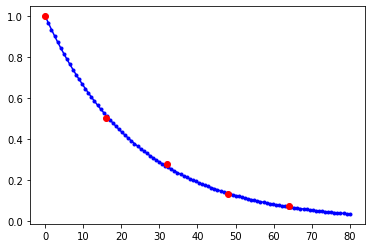

In [19]:
prec =  8 #precision
max_folds = 40 #max number of folds
coeffs, fidelities = fit_fidelity("XY", max_folds, prec) #try for single pauli "XY"

xrange = np.linspace(0, max_folds*2, 100) #as a function of circuit depth
plt.plot(xrange, [np.exp(-coeffs[0]*x) for x in xrange],'b.-') #plot fit
plt.plot(range(0,max_folds*2, prec*2), fidelities, 'ro') #plot data

 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 


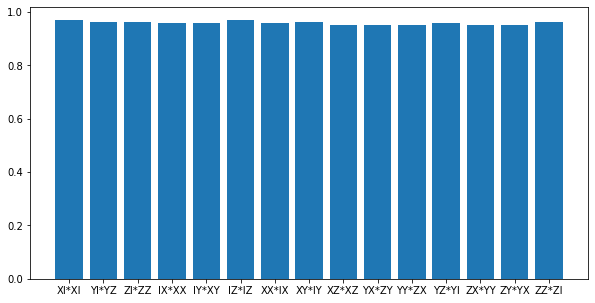

In [20]:
#run the procedure for all paulis in the list
f = generate_full_fidelity_list(10, 2)
p_group_permuted = [get_name(conjugate(pauli_dict[pauli], gate_to_benchmark)) for pauli in pauli_group]
fig, ax = plt.subplots()
ax.bar(range(len(pauli_group)), f)
ax.set_xticks(range(len(pauli_group)), [p1+"*"+p2 for p1,p2 in zip(pauli_group, p_group_permuted)]);
fig.set_size_inches(10, 5, forward=True)

In [38]:
import scipy
np.set_printoptions(precision=5, suppress=False)

def s_prod(a,b):
    return {True:0, False:1}[Pauli(a).commutes(Pauli(b))]

M1 = [[s_prod(a,b) for a in pauli_group] for b in pauli_group]
M2 = [[s_prod(a,b) for a in p_group_permuted] for b in pauli_group]
#This should be invertible, but it is not
M = np.add(M1, M2)

model_coeffs, fit = scipy.optimize.nnls(M, -.5*np.log(f)) 
print(model_coeffs)
print(pauli_group)

[0.00273 0.00321 0.00325 0.00318 0.00329 0.00286 0.      0.      0.00027
 0.00045 0.00069 0.      0.      0.      0.     ]
['XI', 'YI', 'ZI', 'IX', 'IY', 'IZ', 'XX', 'XY', 'XZ', 'YX', 'YY', 'YZ', 'ZX', 'ZY', 'ZZ']


In [37]:
np.linalg.inv(np.add(M1,M2))

LinAlgError: Singular matrix

In [ ]:
get_name(conjugate(Pauli('IX').to_matrix(), CX))

'XX'

In [25]:
list(zip(pauli_group, p_group_permuted))

[('XI', 'XI'),
 ('YI', 'YZ'),
 ('ZI', 'ZZ'),
 ('IX', 'XX'),
 ('IY', 'XY'),
 ('IZ', 'IZ'),
 ('XX', 'IX'),
 ('XY', 'IY'),
 ('XZ', 'XZ'),
 ('YX', 'ZY'),
 ('YY', 'ZX'),
 ('YZ', 'YI'),
 ('ZX', 'YY'),
 ('ZY', 'YX'),
 ('ZZ', 'ZI')]

In [76]:
reduced_p_group = pauli_group
for i,(p,r) in enumerate(zip(pauli_group, p_group_permuted)):
    if 'I' in p or 'I' in r:
        reduced_p_group[i] = r

In [77]:
reduced_p_group

['XI',
 'YZ',
 'ZZ',
 'XX',
 'XY',
 'IZ',
 'IX',
 'IY',
 'XZ',
 'YX',
 'YY',
 'YI',
 'ZX',
 'ZY',
 'ZI']

In [80]:
M1 = [[s_prod(a,b) for a in pauli_group] for b in pauli_group]
M2 = [[s_prod(a,b) for a in reduced_p_group] for b in pauli_group]

In [81]:
np.linalg.inv(np.add(M1,M2))

array([[-0.0625,  0.0625,  0.0625, -0.0625, -0.0625, -0.0625, -0.0625,
        -0.0625, -0.0625,  0.0625,  0.0625,  0.0625,  0.0625,  0.0625,
         0.0625],
       [ 0.0625, -0.0625,  0.0625, -0.0625, -0.0625, -0.0625,  0.0625,
         0.0625,  0.0625,  0.0625,  0.0625, -0.0625, -0.0625, -0.0625,
         0.0625],
       [ 0.0625,  0.0625, -0.0625, -0.0625, -0.0625, -0.0625,  0.0625,
         0.0625,  0.0625, -0.0625, -0.0625,  0.0625,  0.0625,  0.0625,
        -0.0625],
       [-0.0625, -0.0625, -0.0625, -0.0625,  0.0625,  0.0625, -0.0625,
         0.0625,  0.0625,  0.0625, -0.0625,  0.0625,  0.0625, -0.0625,
         0.0625],
       [-0.0625, -0.0625, -0.0625,  0.0625, -0.0625,  0.0625,  0.0625,
        -0.0625,  0.0625, -0.0625,  0.0625,  0.0625, -0.0625,  0.0625,
         0.0625],
       [-0.0625, -0.0625, -0.0625,  0.0625,  0.0625, -0.0625,  0.0625,
         0.0625, -0.0625,  0.0625,  0.0625, -0.0625,  0.0625,  0.0625,
        -0.0625],
       [-0.0625,  0.0625,  0.0625, -0.06

In [72]:
get_name(conjugate(Pauli('YY').to_matrix(), Operator(np.kron(H.compose(S.adjoint()),S.adjoint()))))

'ZX'